## ML Model using CNN and LSTM
import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

load data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# List of CSV files to use for training
# This path is user specific, needs to be changed for the location of your training data
csv_files = ['/content/drive/MyDrive/final_training_data.csv']  # Add more file names as needed

# Load and concatenate data from multiple CSV files
data_list = []
for csv_file in csv_files:
    data = pd.read_csv(csv_file)
    data_list.append(data)

# Concatenate data from all CSV files
data = pd.concat(data_list, ignore_index=True)

In [ ]:
data

,timestamp,Total,Washer,Lights,Dryer,WaterHeater,Recs,HVAC,Other
0,2023-01-18 22:00:00,164.1,0.5,25.7,0.0,0.0,12.7,33.8,91.4
1,2023-01-18 22:01:00,164.3,0.5,25.6,0.0,0.0,12.7,33.8,91.7
2,2023-01-18 22:02:00,164.1,0.6,25.8,0.0,0.0,12.5,33.9,91.3
3,2023-01-18 22:03:00,164.0,0.5,25.6,0.0,0.0,12.7,33.7,91.5
4,2023-01-18 22:04:00,164.2,0.6,25.7,0.0,0.0,12.5,33.8,91.6
...,...,...,...,...,...,...,...,...,...
5452,2023-01-22 22:07:00,1927.9,6.0,43.5,0.1,0.0,13.0,879.7,985.6
5453,2023-01-22 22:09:00,1927.3,6.0,43.3,0.1,0.0,13.0,880.9,984.0
5454,2023-01-22 22:10:00,1926.0,6.0,43.2,0.1,0.0,13.0,880.1,983.6
5455,2023-01-22 22:12:00,1931.8,6.0,43.4,0.1,0.0,13.1,882.3,986.9


preprocess data

In [ ]:
# Preprocess the timestamp column to extract relevant information
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['Hour'] = data['timestamp'].dt.hour
data['DayOfWeek'] = data['timestamp'].dt.dayofweek
data['Month'] = data['timestamp'].dt.month

# Remove negative values for appropriate columns
for column in data.columns:
    if column != 'timestamp':
        data[column] = data[column].clip(lower=0)  # Clip negative values

In [ ]:
data

,timestamp,Total,Washer,Lights,Dryer,WaterHeater,Recs,HVAC,Other,Hour,DayOfWeek,Month
0,2023-01-18 22:00:00,164.1,0.5,25.7,0.0,0.0,12.7,33.8,91.4,22,2,1
1,2023-01-18 22:01:00,164.3,0.5,25.6,0.0,0.0,12.7,33.8,91.7,22,2,1
2,2023-01-18 22:02:00,164.1,0.6,25.8,0.0,0.0,12.5,33.9,91.3,22,2,1
3,2023-01-18 22:03:00,164.0,0.5,25.6,0.0,0.0,12.7,33.7,91.5,22,2,1
4,2023-01-18 22:04:00,164.2,0.6,25.7,0.0,0.0,12.5,33.8,91.6,22,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5452,2023-01-22 22:07:00,1927.9,6.0,43.5,0.1,0.0,13.0,879.7,985.6,22,6,1
5453,2023-01-22 22:09:00,1927.3,6.0,43.3,0.1,0.0,13.0,880.9,984.0,22,6,1
5454,2023-01-22 22:10:00,1926.0,6.0,43.2,0.1,0.0,13.0,880.1,983.6,22,6,1
5455,2023-01-22 22:12:00,1931.8,6.0,43.4,0.1,0.0,13.1,882.3,986.9,22,6,1


define features and targets

In [ ]:
X = data[['Hour', 'DayOfWeek', 'Month', 'Total']].values
y = data[['Washer', 'HVAC', 'Lights', 'Dryer', 'Recs', 'WaterHeater', 'Other']].values

# Normalize features and targets
scaler_X = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y)

import joblib

# Save scaler objects to files
joblib.dump(scaler_X, '/content/drive/MyDrive/scaler_X.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/scaler_y.pkl')

['/content/drive/MyDrive/scaler_y.pkl']

Create sequences
-create sequences/windows of data for LSTM. Length of TIME_STEPS is used below

In [ ]:
# Function to create sequences
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10

# Create sequences
X_seq, y_seq = create_dataset(X_normalized, y_normalized, TIME_STEPS)

split data 80/20 for training and testing

In [ ]:
# Split data into training and testing
split_ratio = 0.8
split_index = int(len(X_seq) * split_ratio)

X_train, y_train = X_seq[:split_index], y_seq[:split_index]
X_test, y_test = X_seq[split_index:], y_seq[split_index:]

define CNN model creation

In [ ]:
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    # Add convolutional layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # Reshape the data for LSTM
    model.add(tf.keras.layers.Reshape((-1, 64)))  # 64 corresponds to the number of filters in the last Conv1D layer
    # Add LSTM layers
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    # Add dense layers
    model.add(Dense(7, activation='linear'))  # Output layer with linear activation for regression
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and compile the model
model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 32)             416       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 50)             2

Train & save model

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
273/273 [==============================] - 14s 10ms/step - loss: 0.0150 - val_loss: 0.0194
Epoch 2/10
273/273 [==============================] - 3s 9ms/step - loss: 0.0082 - val_loss: 0.0155
Epoch 3/10
273/273 [==============================] - 2s 8ms/step - loss: 0.0073 - val_loss: 0.0153
Epoch 4/10
273/273 [==============================] - 2s 6ms/step - loss: 0.0067 - val_loss: 0.0140
Epoch 5/10
273/273 [==============================] - 2s 6ms/step - loss: 0.0062 - val_loss: 0.0145
Epoch 6/10
273/273 [==============================] - 2s 6ms/step - loss: 0.0058 - val_loss: 0.0137
Epoch 7/10
273/273 [==============================] - 2s 6ms/step - loss: 0.0056 - val_loss: 0.0167
Epoch 8/10
273/273 [==============================] - 2s 7ms/step - loss: 0.0054 - val_loss: 0.0137
Epoch 9/10
273/273 [==============================] - 2s 8ms/step - loss: 0.0052 - val_loss: 0.0136
Epoch 10/10
273/273 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.01

In [ ]:
model.save('/content/drive/MyDrive/final_model_category.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing model predictions

35/35 [==============================] - 1s 2ms/step


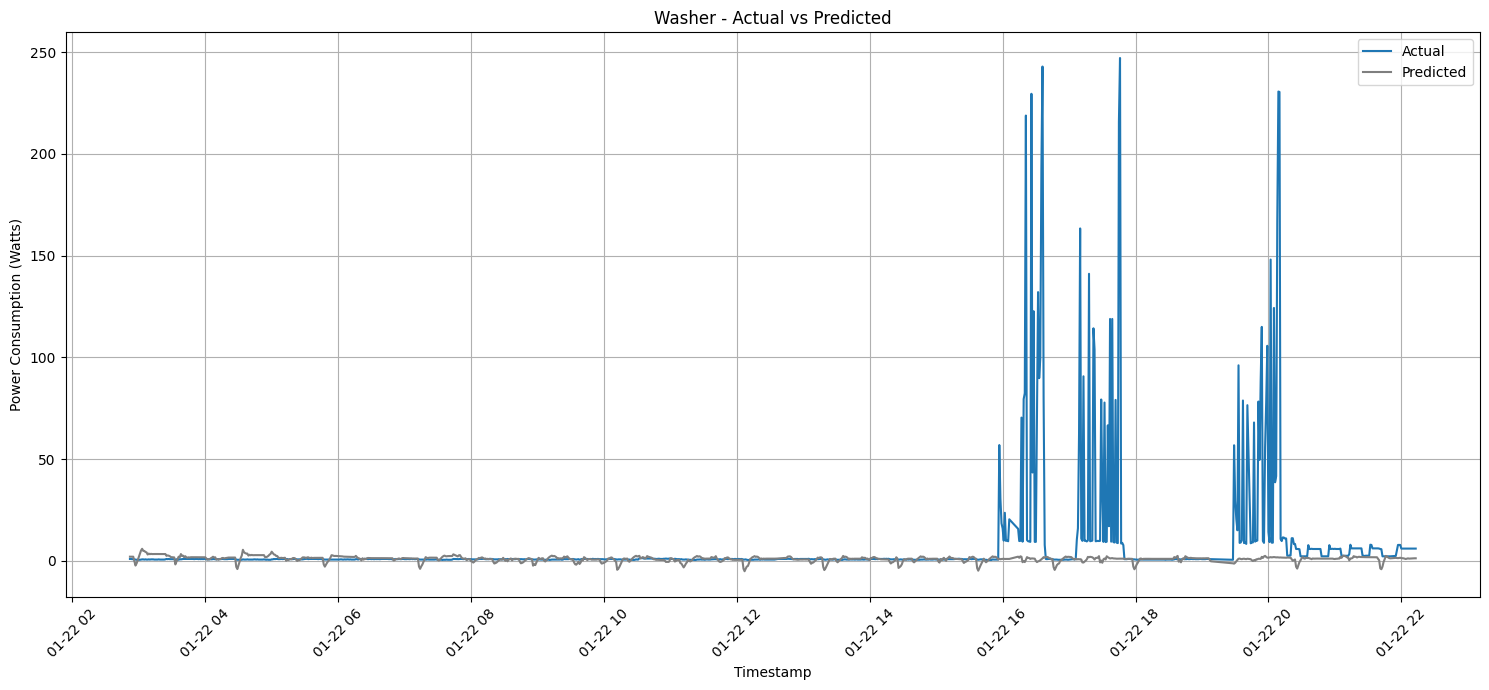

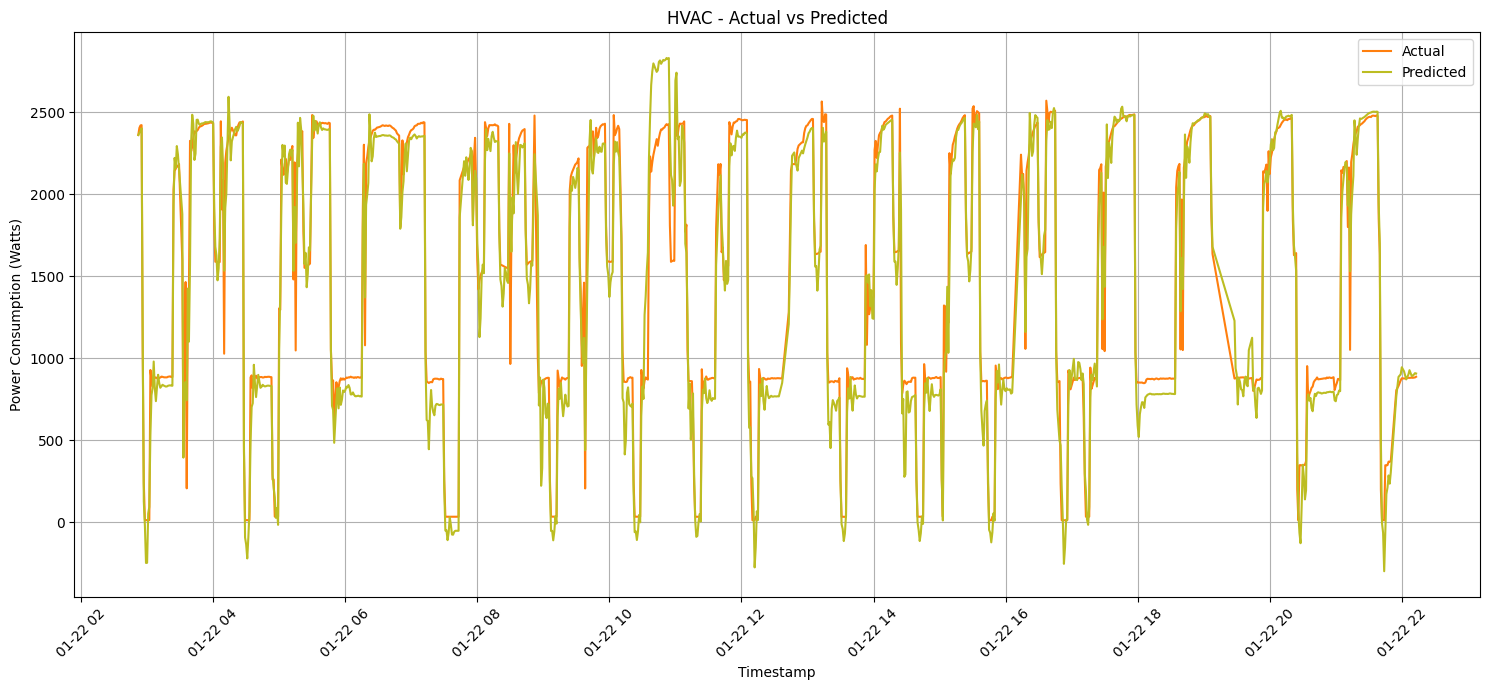

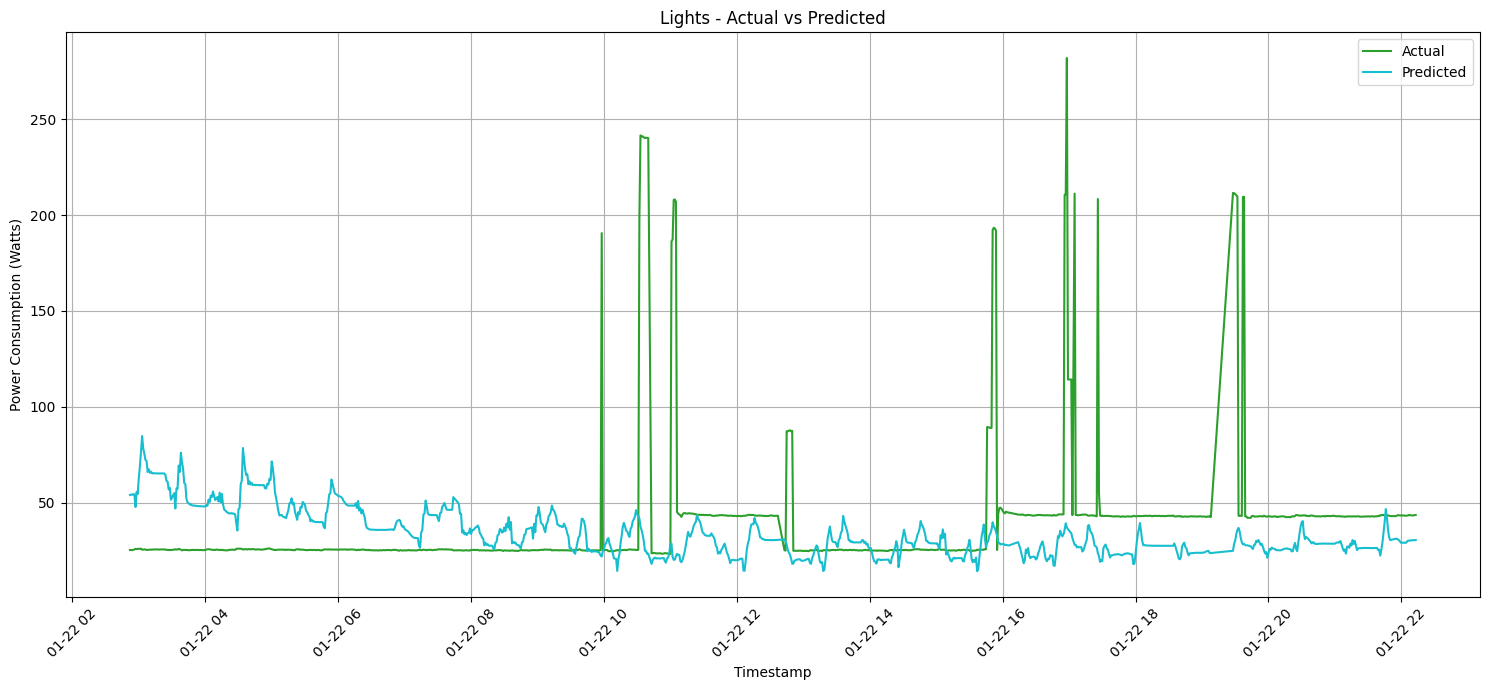

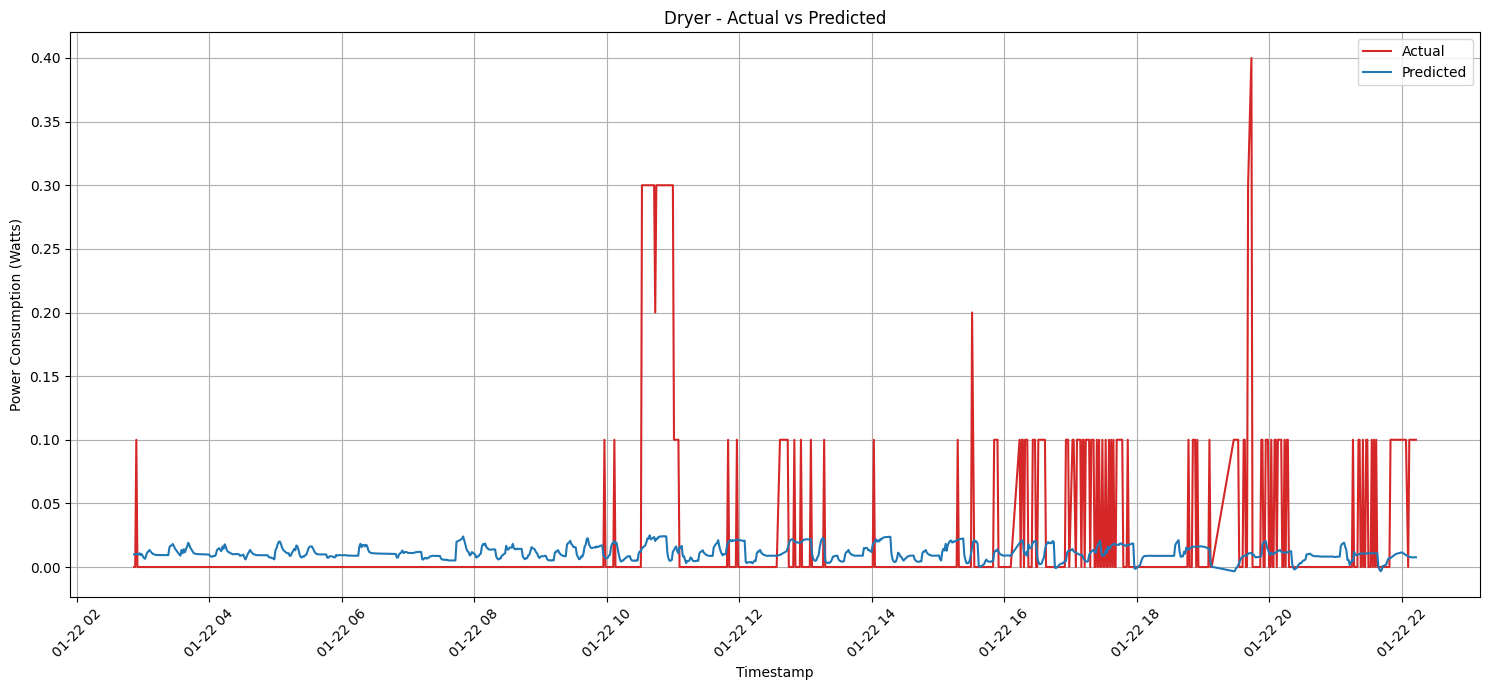

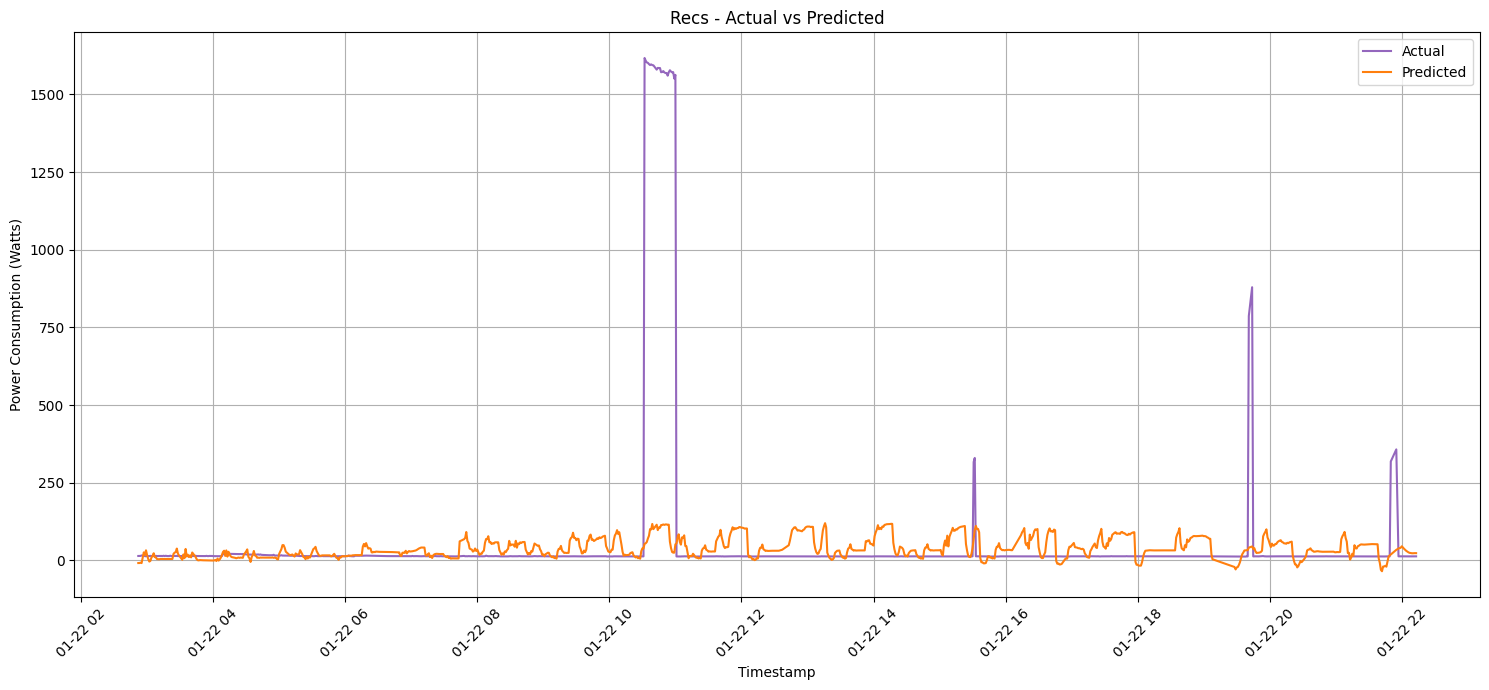

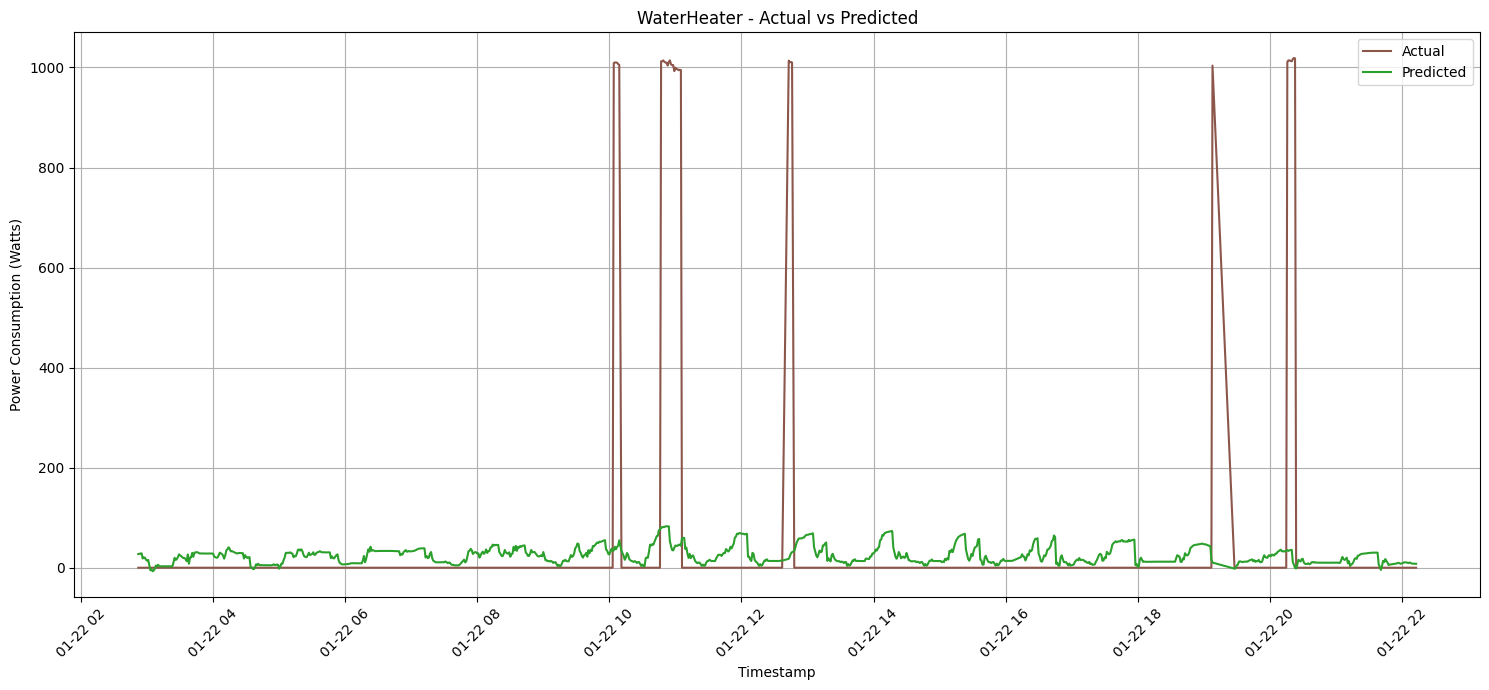

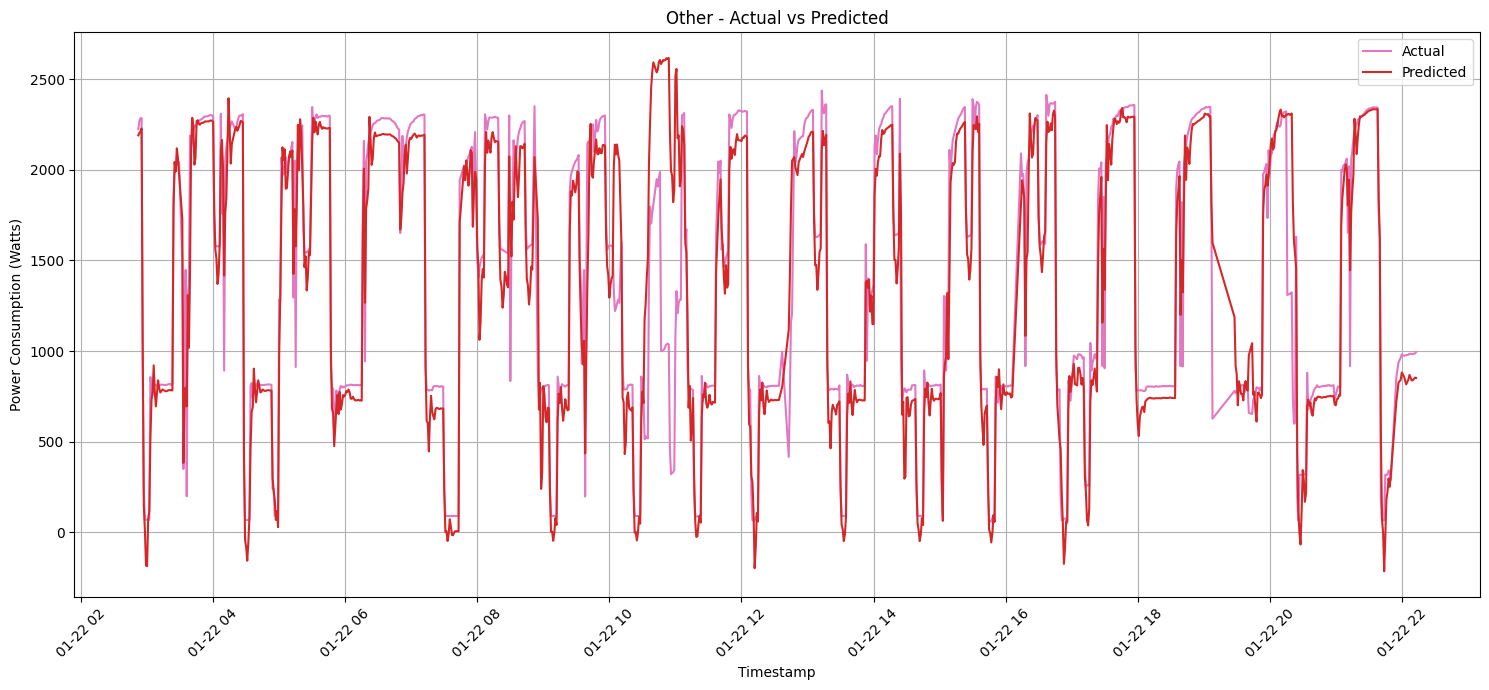

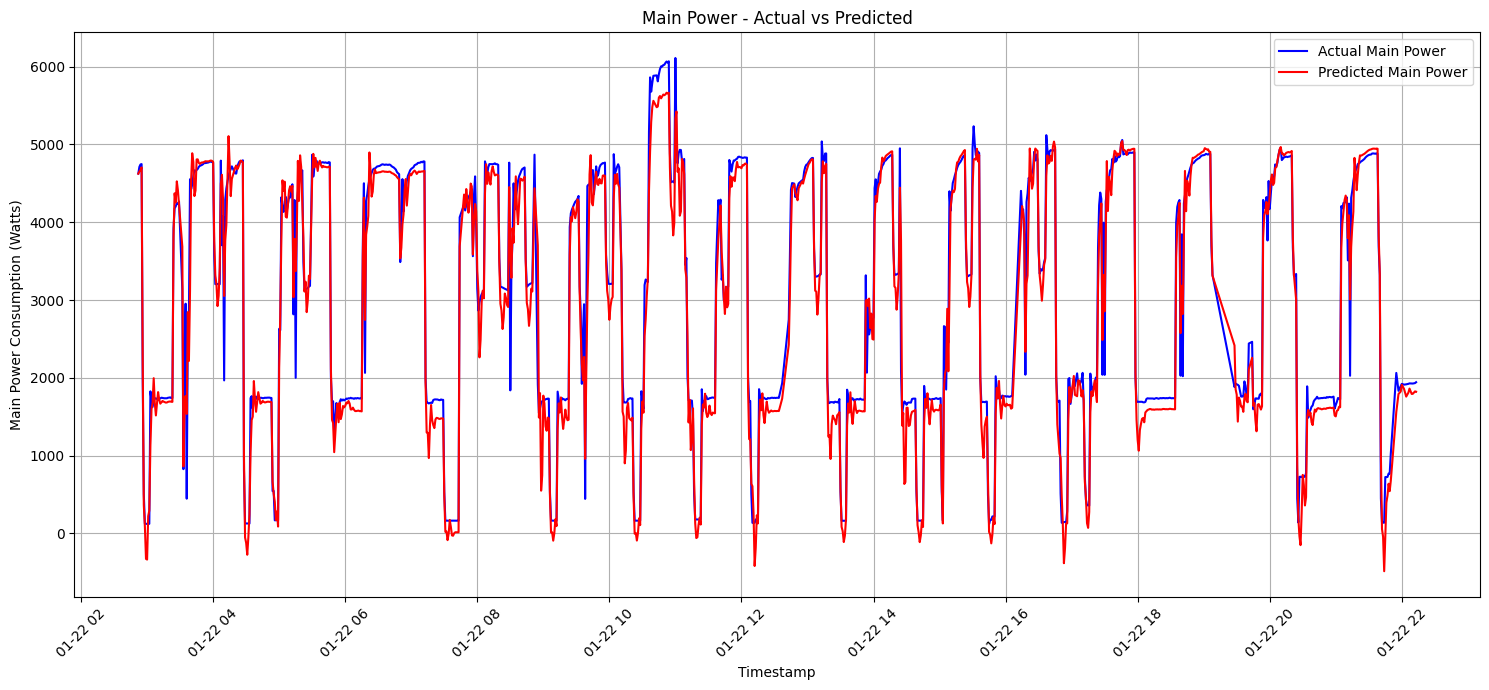

In [ ]:
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get them back in Watts instead of normalized
predicted_values = scaler_y.inverse_transform(predictions)  # Apply inverse transformation
actual_values = scaler_y.inverse_transform(y_test)  # Apply inverse transformation

# Extract timestamps for test
test_timestamps = data['timestamp'].iloc[-len(X_test):]

appliance_names = ['Washer', 'HVAC', 'Lights', 'Dryer', 'Recs', 'WaterHeater', 'Other']

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Appliance', 'Actual Total (Watts)', 'Predicted Total (Watts)', 'Percentage Error'])


for idx, appliance in enumerate(appliance_names):
    plt.figure(figsize=(15, 7))

    # Plot actual usage
    plt.plot(test_timestamps, actual_values[:, idx], label='Actual', color='C'+str(idx))

    # Plot predicted usage
    plt.plot(test_timestamps, predicted_values[:, idx], label='Predicted', color='C'+str(idx+7))

    plt.title(f"{appliance} - Actual vs Predicted")
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (Watts)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Calculate actual and predicted total power in watts for the main power
actual_main_power = actual_values.sum(axis=1)
predicted_main_power = predicted_values.sum(axis=1)

# Plot actual vs predicted main power
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps, actual_main_power, label='Actual Main Power', color='blue')
plt.plot(test_timestamps, predicted_main_power, label='Predicted Main Power', color='red')
plt.title("Main Power - Actual vs Predicted")
plt.xlabel('Timestamp')
plt.ylabel('Main Power Consumption (Watts)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

['/content/drive/MyDrive/scaler_y.pkl']